# <center>Business Analytics Programming II</center> 
# <center> 항공기 지연(Delay) 예측 ML모델 설계 및 개발을 통한 항공 지연 요소 탐색 </center>
# <center> Team Project - EDA</center>
### <div align = "right">Business Analytics</div> 
### <div align = "right">Group 3(전민석, 함보연, 지충근) </div>

In [1]:
import random
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV


In [2]:
train = pd.read_excel('./flight.xlsx')

In [3]:
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000005,4,13,1545.0,NaN,0,0,EWR,11618,NaN,DCA,11278,Virginia,199,Republic Airlines,UA,20452.0,N657RW,Not_Delayed
1,TRAIN_000006,1,20,1742.0,1903.0,0,0,EWR,11618,New Jersey,BOS,10721,Massachusetts,200,United Air Lines Inc.,UA,NaN,N66825,Not_Delayed
2,TRAIN_000008,6,13,1420.0,1550.0,0,0,BWI,10821,NaN,CLT,11057,North Carolina,361,Southwest Airlines Co.,WN,19393.0,N765SW,Not_Delayed
3,TRAIN_000010,8,13,1730.0,1844.0,0,0,DCA,11278,Virginia,PIT,14122,Pennsylvania,204,Republic Airlines,AA,NaN,N119HQ,Delayed
4,TRAIN_000012,1,12,1015.0,1145.0,0,0,CLE,11042,Ohio,DEN,11292,Colorado,1201,Southwest Airlines Co.,WN,NaN,N8696E,Not_Delayed


## 1. 데이터 확인 - Estimated_Departure_Time, Estimated_Arrival_Time, Origin_State, Destination_State, Airline, Carrier_Code(IATA), Carrier_ID(DOT)에 NA 존재

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255001 entries, 0 to 255000
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        255001 non-null  object 
 1   Month                     255001 non-null  int64  
 2   Day_of_Month              255001 non-null  int64  
 3   Estimated_Departure_Time  227160 non-null  float64
 4   Estimated_Arrival_Time    227317 non-null  float64
 5   Cancelled                 255001 non-null  int64  
 6   Diverted                  255001 non-null  int64  
 7   Origin_Airport            255001 non-null  object 
 8   Origin_Airport_ID         255001 non-null  int64  
 9   Origin_State              227145 non-null  object 
 10  Destination_Airport       255001 non-null  object 
 11  Destination_Airport_ID    255001 non-null  int64  
 12  Destination_State         227323 non-null  object 
 13  Distance                  255001 non-null  i

In [5]:
train.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,255001.000000,255001.000000,227160.000000,227317.000000,255001.0,255001.0,255001.000000,255001.000000,255001.000000,227231.000000
mean,6.967996,15.760028,1319.396624,1472.634691,0.0,0.0,12697.605570,12700.041635,779.949455,19995.621531
std,3.469944,8.794969,490.941713,517.545954,0.0,0.0,1516.020456,1515.893547,589.255800,403.702782
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,905.000000,1053.000000,0.0,0.0,11292.000000,11292.000000,349.000000,19790.000000
50%,7.000000,16.000000,1310.000000,1500.000000,0.0,0.0,12889.000000,12889.000000,620.000000,19977.000000
75%,10.000000,23.000000,1730.000000,1910.000000,0.0,0.0,14057.000000,14057.000000,1014.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


## 2. 1차 데이터 Preprocessing

### 1) 날자 변환 -  Month, Day_ofMonth 두개의 Column을 1년 366일(윤달 포함)로 변환한 Day Column 생성

In [6]:
def to_days(x):
    month_to_days = {1:0, 2:31, 3:60, 4:91, 5:121, 6:152, 7:182, 8:213, 9:244, 10:274, 11:305, 12:335}
    return month_to_days[x]

train.loc[:, 'Day'] = train['Month'].apply(lambda x: to_days(x))
train['Day'] = train['Day'] + train['Day_of_Month']

train = train.astype({'Day':object})

### 2) 결측 Airline 데이터 복구 - Carrier_ID(DOT) 이용

데이터의 설명을 보면 Carrier_ID(DOT)은 해당 항공사(Airline) 별로 하나가 할당(1대1 대응). 따라서, 둘 중 하나만 있어도 분류하는데 지장이 없으며(두 데이터는 서로 완전종속이기 때문에), 두 개 모두 결측치가 아닌 이상, 데이터 복구가 가능하다고 가정을 할 수 있다.
따라서, 먼저 복구 가능한 데이터의 개수 (Carrier_ID(DOT)이 존재하면서, Airline이 존재 안하는 row의 개수)를 확인한 후, Airline과 Carrier_ID(DOT)을 이어주는 dictionary 를 만들어서 가능한 Airline를 복구합니다.
###  - carrier_ID(DOT) 을 통해 복구 가능한 Airline데이터의 개수 파악 및 복구(24,555개)

In [7]:
cond1 = ~train['Carrier_ID(DOT)'].isnull()
cond2 = train['Airline'].isnull()
print("Airline 복구 가능한 데이터의 개수 :", len(train.loc[cond1 & cond2, :]))

Airline 복구 가능한 데이터의 개수 : 24555


### - Carrier_ID(DOT) to Airline dictinary 만들기

In [8]:
# airline to carrier id, dictinary 만들기
# 모두 데이터가 존재하는 열에서 Dict[Airline] = carrier_ID(DOT) 가 되도록 dictionary 생성
cid_to_airline = {}
for _, row in train[(~train['Carrier_ID(DOT)'].isnull() & ~train['Airline'].isnull())].iterrows():
    cid_to_airline[row['Carrier_ID(DOT)']] = row['Airline']

### - Airline 복구

In [9]:
# 복구하기
def to_cid(x):
    return cid_to_airline[x]

cond1 = ~train['Carrier_ID(DOT)'].isnull()
cond2 = train['Airline'].isnull()
train.loc[cond1&cond2, 'Airline'] = train.loc[cond1&cond2, 'Carrier_ID(DOT)'].apply(lambda x: to_cid(x))

### - 복구 안 된 Carrier_ID는 학습에 방해되므로 제거(2,985개)

In [10]:
train['Airline'].isnull().sum()

2985

In [11]:
train = train.dropna(subset=['Airline'], how='any', axis=0)

### 3) Arrival Time & Departure Time 변환  </n>
### - 1440분(1일 = 60분 * 24)으로 바꿔주기

In [12]:
def to_minutes(x):
    x = int(x)
    x = str(x)
    if len(x) > 2:
        hours, mins = int(x[:-2]), int(x[-2:])
    else:
        hours, mins = 0, int(x[-2:])
    return hours*60+mins

estimated_times = ['Estimated_Departure_Time', 'Estimated_Arrival_Time']

for ET in estimated_times:
    cond = ~train[ET].isnull()
    train.loc[cond, ET] = train.loc[cond, ET].apply(lambda x: to_minutes(x))

### - Arrival Time & Departure Time NA값 제거하기

In [13]:
train = train.dropna(subset=['Estimated_Arrival_Time', 'Estimated_Departure_Time'], axis=0)

### 4) Arrival Time & Departure Time을 이용해 비행시간 계산하기


In [14]:
train['Flight_Time'] = train['Estimated_Arrival_Time'] - train['Estimated_Departure_Time']

### 5) 1차전처리 결과 확인

In [15]:
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,...,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Day,Flight_Time
1,TRAIN_000006,1,20,1062.0,1143.0,0,0,EWR,11618,New Jersey,...,10721,Massachusetts,200,United Air Lines Inc.,UA,NaN,N66825,Not_Delayed,20,81.0
2,TRAIN_000008,6,13,860.0,950.0,0,0,BWI,10821,NaN,...,11057,North Carolina,361,Southwest Airlines Co.,WN,19393.0,N765SW,Not_Delayed,165,90.0
3,TRAIN_000010,8,13,1050.0,1124.0,0,0,DCA,11278,Virginia,...,14122,Pennsylvania,204,Republic Airlines,AA,NaN,N119HQ,Delayed,226,74.0
4,TRAIN_000012,1,12,615.0,705.0,0,0,CLE,11042,Ohio,...,11292,Colorado,1201,Southwest Airlines Co.,WN,NaN,N8696E,Not_Delayed,12,90.0
5,TRAIN_000013,9,19,375.0,426.0,0,0,MAF,13158,Texas,...,11292,Colorado,563,SkyWest Airlines Inc.,UA,20304.0,N165SY,Not_Delayed,263,51.0


### 6) 사용하지 않는 column Drop

In [16]:
train = train.drop(['ID', 'Month', 'Day_of_Month', 'Cancelled', 'Diverted', 'Origin_Airport', 'Destination_Airport', 'Carrier_Code(IATA)','Carrier_ID(DOT)', 'Origin_State', 'Destination_State'], axis=1)


### 7) 2차 전처리 이전의 최종 Table -  알고리즘에 맞게 2차 전처리 예정

In [17]:
train.head()

,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Airline,Tail_Number,Delay,Day,Flight_Time
1,1062.0,1143.0,11618,10721,200,United Air Lines Inc.,N66825,Not_Delayed,20,81.0
2,860.0,950.0,10821,11057,361,Southwest Airlines Co.,N765SW,Not_Delayed,165,90.0
3,1050.0,1124.0,11278,14122,204,Republic Airlines,N119HQ,Delayed,226,74.0
4,615.0,705.0,11042,11292,1201,Southwest Airlines Co.,N8696E,Not_Delayed,12,90.0
5,375.0,426.0,13158,11292,563,SkyWest Airlines Inc.,N165SY,Not_Delayed,263,51.0


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200121 entries, 1 to 255000
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Estimated_Departure_Time  200121 non-null  float64
 1   Estimated_Arrival_Time    200121 non-null  float64
 2   Origin_Airport_ID         200121 non-null  int64  
 3   Destination_Airport_ID    200121 non-null  int64  
 4   Distance                  200121 non-null  int64  
 5   Airline                   200121 non-null  object 
 6   Tail_Number               200121 non-null  object 
 7   Delay                     200121 non-null  object 
 8   Day                       200121 non-null  object 
 9   Flight_Time               200121 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 16.8+ MB


In [19]:
train.describe()

,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,Distance,Flight_Time
count,200121.000000,200121.000000,200121.000000,200121.000000,200121.000000,200121.000000
mean,802.499793,895.387995,12697.347795,12700.589358,779.442642,92.888203
std,295.266908,310.524394,1516.817688,1516.390740,589.221524,237.817874
min,1.000000,1.000000,10135.000000,10135.000000,16.000000,-1414.000000
25%,545.000000,654.000000,11292.000000,11292.000000,349.000000,76.000000
50%,790.000000,900.000000,12889.000000,12889.000000,618.000000,107.000000
75%,1050.000000,1150.000000,14057.000000,14057.000000,1014.000000,164.000000
max,1439.000000,1440.000000,16869.000000,16869.000000,5095.000000,675.000000


## 3. 2차 Data Preprocessing (Object변환 for CatBoost)

CatBoost는 Category 변수를 활용한 분류에 최적화된 알고리즘으로 알고리즘에 데이터를 학습시키기 위해 모든 변수들의 Data Type을 Object형태로 변환하여 적용하는 과정이 필수적이다.

### 1) EDT, EAT 의 Object 처리

특정 비행기 출발 혹은 도착 시간대가 비행기 연착에 영향을 미칠 것으로 생각했습니다. 따라서 EDT, EAT경우 30분 단위로 48개의 bin에 담아서 object화 해주었습니다. 그렇게 함으로써 비슷한 시간대의 출/도착편(30분 단위)은 같은 특성을 갖도록 했습니다.

In [20]:
# EDT, EAT 48개의 bins에 담으면 된다. 1440(60*24) 계니까, 48씩 끊어서 하면 될 듯
estimate_times = ['Estimated_Departure_Time', 'Estimated_Arrival_Time']
names = {'Estimated_Departure_Time':'EDT', 'Estimated_Arrival_Time':'EAT'}
for ET in estimated_times:
    for i in range(48):
        train.loc[train[ET].between(i*30, (i+1)*30, 'left'), names[ET]] = i

train = train.astype({'EDT':int, 'EAT':int})

train = train.drop(['Estimated_Departure_Time', 'Estimated_Arrival_Time'], axis=1)

### 2) Flight_Time 의 Object 처리

특정 비행소요시간이 비행기 연착에 영향을 미칠 것으로 생각했습니다. 따라서 비행시간(Flight_Time)을경우 30분 단위로 23개(Flight_Time의 Max = 675)의 bin에 담아서 object화 해주었습니다. 그렇게 함으로써 비슷한 비행시간(30분 단위)은 같은 특성을 갖도록 했습니다.

In [21]:
train['FT'] = train['Flight_Time']//30
train = train.drop(['Flight_Time'], axis=1)

### 3) Distance 의 Object 처리

특정 비행거리가 비행기 연착에 영향을 미칠 것으로 생각했습니다. 따라서 비행거리(Distance)을경우 100mile 단위로 51개(Distance의 Max = 5,100)의 bin에 담아서 object화 해주었습니다. 그렇게 함으로써 비슷한 비행거리(100mile 단위)은 같은 특성을 갖도록 했습니다.

In [22]:
for i in range(51):
    train.loc[train['Distance'].between(i*100, (i+1)*100, 'left'), 'Distance'] = i

train = train.astype({'Distance':int})



### 4) 전체 변수의 Object 변환

In [23]:
train = train.astype({'EDT':object, 'EAT':object, 'Distance':object, 'Origin_Airport_ID':object, 'Destination_Airport_ID':object, 'Airline':object, 'Tail_Number':object, 'FT':object})

## CatBoost 적용을 위한 Dataset 

In [24]:
train.head()

,Origin_Airport_ID,Destination_Airport_ID,Distance,Airline,Tail_Number,Delay,Day,EDT,EAT,FT
1,11618,10721,1,United Air Lines Inc.,N66825,Not_Delayed,20,35,38,2
2,10821,11057,3,Southwest Airlines Co.,N765SW,Not_Delayed,165,28,31,3
3,11278,14122,2,Republic Airlines,N119HQ,Delayed,226,35,37,2
4,11042,11292,12,Southwest Airlines Co.,N8696E,Not_Delayed,12,20,23,3
5,13158,11292,5,SkyWest Airlines Inc.,N165SY,Not_Delayed,263,12,14,1


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200121 entries, 1 to 255000
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Origin_Airport_ID       200121 non-null  object
 1   Destination_Airport_ID  200121 non-null  object
 2   Distance                200121 non-null  object
 3   Airline                 200121 non-null  object
 4   Tail_Number             200121 non-null  object
 5   Delay                   200121 non-null  object
 6   Day                     200121 non-null  object
 7   EDT                     200121 non-null  object
 8   EAT                     200121 non-null  object
 9   FT                      200121 non-null  object
dtypes: object(10)
memory usage: 16.8+ MB


In [26]:
train.describe()

,Origin_Airport_ID,Destination_Airport_ID,Distance,Airline,Tail_Number,Delay,Day,EDT,EAT,FT
count,200121,200121,200121,200121,200121,200121,200121,200121,200121,200121.0
unique,374,373,44,28,6282,2,365,48,48,54.0
top,13930,13930,3,Southwest Airlines Co.,N485HA,Not_Delayed,326,12,34,2.0
freq,9663,10089,21644,40639,122,164817,773,9618,6519,47227.0


최종 데이터의 수는 200121개이며 이중 타겟 변수인 Delay의 Data Imbalance를 확인한 결과 지연편(35,304편), 정시도착(164,817편)으로 21:79의 비율로 지연항공편이 확인되었다.

독립변수를 확인하면 총 365일동안 항공편이 운항되었으며 공항의 수는 출발공항 374개, 도착공항 373개이고, 총 28개 항공사에서 6,282개의 항공기(Tail_Number 기준)가 존재하는것으로 확인하였다. 

향후 CatbBoost를 적용한 모델 학습시에 Data Imbalance를 확인하여 Data Split을 진행하여야 할 필요가 있다.

## 4. Data Preparation  (Next Step)

In [28]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder


In [29]:
qual_col = train.columns

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    

print('Done.')

Done.


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200121 entries, 1 to 255000
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   Origin_Airport_ID       200121 non-null  int32
 1   Destination_Airport_ID  200121 non-null  int32
 2   Distance                200121 non-null  int32
 3   Airline                 200121 non-null  int32
 4   Tail_Number             200121 non-null  int32
 5   Delay                   200121 non-null  int32
 6   Day                     200121 non-null  int32
 7   EDT                     200121 non-null  int32
 8   EAT                     200121 non-null  int32
 9   FT                      200121 non-null  int32
dtypes: int32(10)
memory usage: 9.2 MB


In [31]:
train = train.astype({'EDT':object, 'EAT':object, 'Distance':object, 'Origin_Airport_ID':object, 'Destination_Airport_ID':object, 'Airline':object, 'Tail_Number':object, 'FT':object,'Delay':object, 'Day':object})

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200121 entries, 1 to 255000
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Origin_Airport_ID       200121 non-null  object
 1   Destination_Airport_ID  200121 non-null  object
 2   Distance                200121 non-null  object
 3   Airline                 200121 non-null  object
 4   Tail_Number             200121 non-null  object
 5   Delay                   200121 non-null  object
 6   Day                     200121 non-null  object
 7   EDT                     200121 non-null  object
 8   EAT                     200121 non-null  object
 9   FT                      200121 non-null  object
dtypes: object(10)
memory usage: 16.8+ MB


In [33]:
train.describe()

,Origin_Airport_ID,Destination_Airport_ID,Distance,Airline,Tail_Number,Delay,Day,EDT,EAT,FT
count,200121,200121,200121,200121,200121,200121,200121,200121,200121,200121
unique,374,373,44,28,6282,2,365,48,48,54
top,257,256,3,23,2437,1,324,12,34,35
freq,9663,10089,21644,40639,122,164817,773,9618,6519,47227


### Delay = 0, Not_Delay = 1으로 변환됨.

In [34]:
train_x = train.drop(columns=['Delay'])
train_y = train['Delay']

In [35]:
column_number = {}
for i, column in enumerate(train_x.columns):
    column_number[column] = i

In [36]:
train_x.rename(columns = column_number, inplace = True)

In [69]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=True)


### 1) RandomForest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train.astype('int'))

RandomForestClassifier()

In [40]:
rf.predict(X_val)

array([1, 1, 1, ..., 1, 1, 1])

In [70]:
score1 = rf.predict_proba(X_val)[:, 1]

### 2) CatBoost

In [42]:
cat_cols = X_train.columns[X_train.dtypes == 'object'].to_list()

In [43]:
cat_features = cat_cols
model = CatBoostClassifier(random_seed=42, cat_features=cat_cols, verbose=0)
model.fit(X_train, y_train)

In [44]:
prediction = model.predict(X_val)

In [72]:
score2 =  model.predict_proba(X_val)[:, 1]

### 3) Suppert Vector Machine

In [46]:
from sklearn import svm

In [47]:
svm = RandomForestClassifier()
svm.fit(X_train, y_train.astype('int'))

RandomForestClassifier()

In [48]:
svm.predict(X_val)

array([1, 1, 1, ..., 1, 1, 1])

In [71]:
score3 =  svm.predict_proba(X_val)[:, 1]

### ROC Curve & AUC

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
import matplotlib.pyplot as plt

In [75]:
list_y = y_val.to_list()

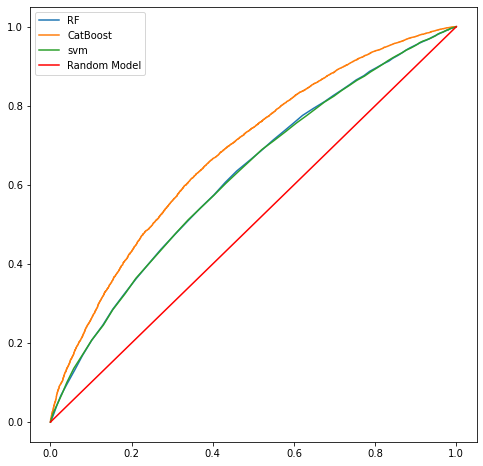

In [76]:

## False Positive Rate, True Positive Rate, 절단값 리턴
fpr1, tpr1, cut1 = roc_curve(list_y, score1)
fpr2, tpr2, cut2 = roc_curve(list_y, score2)
fpr3, tpr3, cut3 = roc_curve(list_y, score3)
 
## ROC 곡선 그리기
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.plot(fpr1, tpr1, label='RF')
ax.plot(fpr2, tpr2, label='CatBoost')
ax.plot(fpr3, tpr3, label='svm')
ax.plot([0, 1], [0, 1], color='red', label='Random Model')
ax.legend()
plt.show()

In [78]:
print('roc_auc_score')
print('RF', roc_auc_score(list_y, score1))
print('CatBoost', roc_auc_score(list_y, score2))
print('SVM', roc_auc_score(list_y, score3))

roc_auc_score
RF 0.6213591739144357
CatBoost 0.6823336158747161
SVM 0.6203690829670496
